# Sparkify EDA


In this notebook we do the exploratory data analysis with the mini data set (128MB)

In [1]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf, desc, asc, avg, col, concat, desc, explode, lit, min, max, split, count
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum

import datetime
from time import time

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from functools import reduce


In [2]:
# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler,StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression,RandomForestClassifier,LinearSVC 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
sparkify_mini_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_mini_data)
df.persist()
# See the df schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
print("Initial count before clean up: ", df.count(), ', and no of columns :', len(df.columns))
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
#unique users
print("Total number of unique users in the dataset:", df.select('userId').dropDuplicates().count())
#unique pages
print("Total number of unique pages in the dataset:", df.select('page').dropDuplicates().count())


Initial count before clean up:  286500 , and no of columns : 18
Total number of unique users in the dataset: 226
Total number of unique pages in the dataset: 22


In [7]:
#time stamp
#https://www.programiz.com/python-programming/datetime/timestamp-datetime
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [8]:
#the timestamp in the data is ticks (ms)
#timestamp func needs second as its input
ticks_to_sec=1./1000. #convert from ms to seconds
ticks_to_hours = ticks_to_sec/( 60.0 * 60.0)
ticks_to_days = ticks_to_hours/24.

#time stamp analysis, convert ts and registrtaion time stamps
#then add these two columns to dataframe
#see https://stackoverflow.com/questions/51983037/convert-from-timestamp-to-specific-date-in-pyspark
format_timestamp_udf= udf(lambda x: datetime.datetime.fromtimestamp(x*ticks_to_sec).strftime("%Y-%m-%d %H:%M:%S"))

In [9]:
ts_min_fromdf = 1538352117000
ts_max_fromdf = 1543799476000
print("Data are from    ")
print("start time    :",datetime.datetime.fromtimestamp(ts_min_fromdf*ticks_to_sec).strftime("%Y-%m-%d %H:%M:%S"))
print("end time      :",datetime.datetime.fromtimestamp(ts_max_fromdf*ticks_to_sec).strftime("%Y-%m-%d %H:%M:%S"))

#ts = int(1543799476000)
#ts /= 1000
#print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Data are from    
start time    : 2018-10-01 00:01:57
end time      : 2018-12-03 01:11:16


In [10]:
#let us explore the possible values of some categoric columns
col_str = ['auth','level', 'method', 'page', 'status']
for col in col_str:
    df.select(col).distinct().show(50,False)     
    

+----------+
|auth      |
+----------+
|Logged Out|
|Cancelled |
|Guest     |
|Logged In |
+----------+

+-----+
|level|
+-----+
|free |
|paid |
+-----+

+------+
|method|
+------+
|PUT   |
|GET   |
+------+

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+

+------+
|status|
+------+
|307   |
|404   |
|200   |
+------+

In [11]:
#let us look at the page feature in more detail
page_tmp = df.groupby('page').count().sort('count', ascending=False)
page_tmp_count = page_tmp.toPandas().set_index('page')
page_tmp_count

,count
page,
NextSong,228108
Home,14457
Thumbs Up,12551
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Login,3241
Logout,3226
Thumbs Down,2546


In [12]:
#get all details of the  first log entry via spark, with vertical display
df.show(1,vertical=True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
only showing top 1 row



In [13]:
df.describe().show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



Clearly, some of the rows have some missing values. 

In [14]:
# first let us check columns with empty string values, 12 out of 18 are strings
col_str = ['artist', 'auth', 'firstName','gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']
for col in col_str:
    print("Number of empty string value in column", col, 'is', df.select(['userId']).where(df[col] == '').count())
        

Number of empty string value in column artist is 0
Number of empty string value in column auth is 0
Number of empty string value in column firstName is 0
Number of empty string value in column gender is 0
Number of empty string value in column lastName is 0
Number of empty string value in column level is 0
Number of empty string value in column location is 0
Number of empty string value in column method is 0
Number of empty string value in column page is 0
Number of empty string value in column song is 0
Number of empty string value in column userAgent is 0
Number of empty string value in column userId is 8346


There are some empty values for the userid variable as shown above, this might be the unregistered or logged out users just casually browsing. We need to get rid of these since it doesn't add anything to our  churn studies

In [15]:
def cleanDF(df):
    '''
    Clean data frame to avoid empty values.
    
    INPUT: dataframe
    
    OUTPUT: cleaned dataframe
    '''
    df_cleaned = df.filter(df["userId"] != "")
    
    return df_cleaned

In [16]:
df = cleanDF(df)
print("Count after cleaning (empty values) userid: ", df.count())

Count after cleaning (empty values) userid:  278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [17]:
print("Number of distinct artists :", df.select('artist').distinct().count())
print("Number of distinct songs: ", df.select('song').distinct().count())
print("Number of distinct firstName: ", df.select('firstName').distinct().count())
print("Number of distinct lastName: ", df.select('lastName').distinct().count())
print("Number of distinct sessionIDs: ", df.select('sessionId').distinct().count())

Number of distinct artists : 17656
Number of distinct songs:  58481
Number of distinct firstName:  189
Number of distinct lastName:  173
Number of distinct sessionIDs:  2312


### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [18]:
churnedUsers = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()

In [19]:
#make a list for churned users
churnedUsersList=[]
for row in churnedUsers.collect():
    churnedUsersList.append((row['userId']))  

In [20]:
#make a df with info containing churned users                       
df= df.withColumn("churn", df.userId.isin(churnedUsersList))
dfp=df.toPandas()
dfp.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

##### Churned vs stayed

In [21]:
stayed = df.select('userId', 'churn').where(df.churn == 'False').groupBy('userId').count().agg(count("count"))
churn= df.select('userId', 'churn').where(df.churn == 'True').groupBy('userId').count().agg(count("count"))
churn_count=churn.collect()[0]["count(count)"]
stayed_count=stayed.collect()[0]["count(count)"]
print ('Number of people churned', churn_count, 'with a churn ratio ',churn_count/ (churn_count+ stayed_count))

Number of people churned 52 with a churn ratio  0.2311111111111111


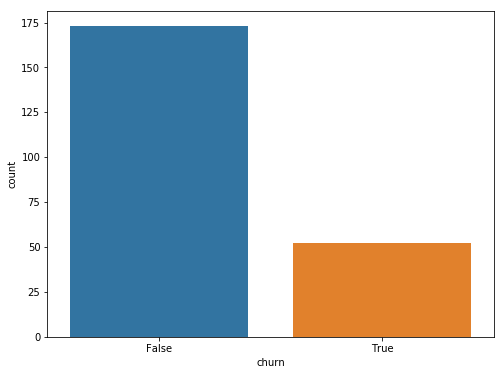

In [22]:
dfp_tmp = df.dropDuplicates(['userId']).groupby(['churn']).count().toPandas()
#sns.barplot(x="churn", y="count", data=dfp_tmp)
plt.figure(figsize=(8,6)) 
#plt.grid(axis='both',linewidth=0.5)
sns.barplot(x="churn", y="count", data=dfp_tmp)
plt.savefig('churnVsStayed_mini.png')

######  Churned vs stayed : Gender distribution

In [23]:
male = df.select('userId', 'gender').where(df.gender == 'M').groupBy('userId').count().agg(count("count"))
male_count=male.collect()[0]["count(count)"]
female = df.select('userId', 'gender').where(df.gender == 'F').groupBy('userId').count().agg(count("count"))
female_count=female.collect()[0]["count(count)"]

print ('Number of females ', female_count, ';  number of males ',male_count)

Number of females  104 ;  number of males  121


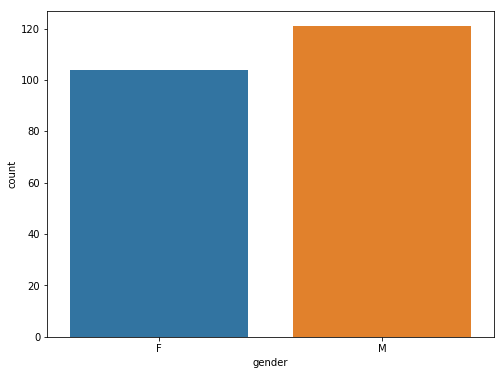

In [24]:
dfp_tmp = df.dropDuplicates(['userId']).groupby(['gender']).count().toPandas()

plt.figure(figsize=(8,6)) 
sns.barplot(x="gender", y="count", data=dfp_tmp)
plt.savefig('churnVsStayedGender_mini.png')


In [25]:
df.dropDuplicates(['userId']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



######  Churned vs stayed : analysis of different page settings 

In [26]:
churn_df = dfp[dfp.churn == True].groupby(['page'])['userId'].count()
churn_df = (churn_df /churn_df.sum())*100 

stayed_df = dfp[dfp.churn == False].groupby(['page'])['userId'].count()
stayed_df = (stayed_df/stayed_df.sum())*100

In [27]:
tmp_df = pd.DataFrame({'Churned': churn_df,'Stayed': stayed_df})
tmp_df['pcnt_difference'] = tmp_df['Stayed']- tmp_df['Churned']                      
tmp_df

,Churned,Stayed,pcnt_difference
About,0.124822,0.188178,0.063356
Add Friend,1.417618,1.560718,0.143101
Add to Playlist,2.313659,2.352437,0.038778
Cancel,0.115906,NaN,NaN
Cancellation Confirmation,0.115906,NaN,NaN
Downgrade,0.751159,0.736422,-0.014737
Error,0.071327,0.094303,0.022977
Help,0.532721,0.520811,-0.011910
Home,3.726819,3.604955,-0.121864
Logout,1.232614,1.145784,-0.086830


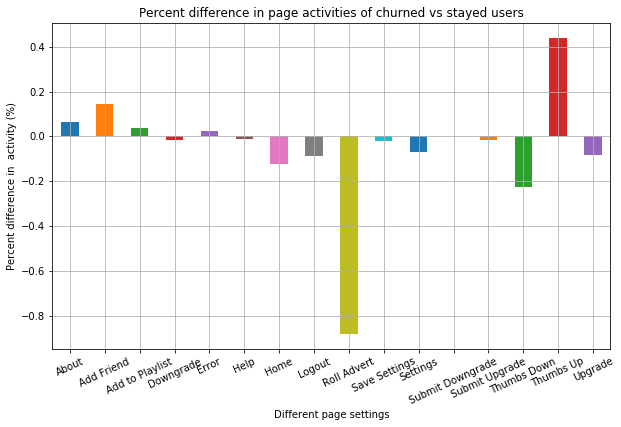

In [28]:
tmp_df.drop(index=['NextSong', 'Cancel', 'Cancellation Confirmation'],inplace=True)
ax = tmp_df['pcnt_difference'].plot(kind='bar', figsize=(10,6));
ax.set_xlabel('Different page settings')
ax.set_ylabel('Percent difference in  activity (%)')
plt.xticks(rotation=25)
plt.grid()
ax.set_title('Percent difference in page activities of churned vs stayed users');
plt.savefig('pcntDiffPageActivity_mini.png')

Since we have played around with the data a bit next step is to do feature engineering and ML modeling. This will be in seperate notebooks